<a href="https://colab.research.google.com/github/SergeyShchus/GIS_Portal/blob/master/Notebook/Colab/Find_the_top_'n'_items_in_your_org.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Эта записная книжка будет работать с таким сценарием использования, чтобы находить самые популярные 100общедоступные элементы ArcGIS Dashboard , отсортированные по количеству просмотров, и выводить результаты в файл CSV, который можно использовать для составления отчетов или загрузить в любую другую систему.

In [1]:
!pip install arcgis

In [6]:
import arcgis

from arcgis.gis import GIS

gis = GIS()

In [25]:
# set up time zone for searching - 'PDT' in this example
la_tz = tz.gettz('America/Los_Angeles')

# set up a time filter - last 20 days in this example
end_time = datetime.now(tz=la_tz)
start_time = end_time - timedelta(days=20)

# sort order
search_sort_order = 'desc'

# search outside org?
search_outside_org = True

# number of items to search for
search_items_max = 100

# search item type
search_item_type = "Dashboard"

# output location
out_folder = '/content/gis'

ArcGIS хранит время createdи modifiedдля элементов в виде миллисекундных временных меток Unix Epoch в часовом поясе UTC . Следующая ячейка преобразует время начала и окончания в часовой пояс UTC, а затем в эпоху. Мы умножаем на 1000, чтобы преобразовать секунды в миллисекунды.

In [8]:
end_time_epoch = end_time.astimezone(tz.UTC).timestamp()*1000
start_time_epoch = start_time.astimezone(tz.UTC).timestamp()*1000

# print settings
print(f'Time zone used: {end_time.tzname()}')
print(f'start time: {start_time} | as epoch: {start_time_epoch}')
print(f'end time: {end_time} | as epoch: {end_time_epoch}')

Time zone used: PDT
start time: 2021-03-04 23:22:13.971604-08:00 | as epoch: 1614928933971.604
end time: 2021-03-24 23:22:13.971604-07:00 | as epoch: 1616653333971.604


создадим поисковый запрос

In [9]:
query_string = f'modified: [{start_time_epoch} TO {end_time_epoch}]'

# search 100 most popular ArcGIS Dashboard items across all of ArcGIS Online
search_result = gis.content.search(query=query_string, item_type=search_item_type, 
                                   sort_field='numViews', sort_order=search_sort_order,
                                   max_items=search_items_max, outside_org=search_outside_org)
len(search_result)

100

составим список объектов словаря из результатов поиска и выберем важные свойства элемента, такие как идентификатор элемента, заголовок, URL-адрес, время создания, количество просмотров и т. Д.

In [10]:
%%time
result_list = []

for current_item in search_result:
    result_dict = {}
    result_dict['item_id'] = current_item.id
    result_dict['num_views'] = current_item.numViews
    result_dict['title'] = current_item.title
    
    # process creation date
    date_modified = datetime.fromtimestamp(current_item.modified/1000, tz=tz.UTC)
    result_dict['date_modified'] = date_modified
    
    result_dict['url'] = current_item.homepage
    
    # append to list
    result_list.append(result_dict)

CPU times: user 1.45 ms, sys: 0 ns, total: 1.45 ms
Wall time: 2.95 ms


In [11]:
df = pd.DataFrame(data=result_list)

In [12]:
df.head() # top 5

,item_id,num_views,title,date_modified,url
0,bda7594740fd40299423467b48e9ecf6,221243205,Coronavirus COVID-19 (2019-nCoV),2021-03-08 19:58:31+00:00,https://www.arcgis.com/home/item.html?id=bda75...
1,35b6123fb22244f786b140131c502b10,155512960,RKI COVID-19 Germany Mobil,2021-03-25 02:08:59+00:00,https://www.arcgis.com/home/item.html?id=35b61...
2,bca904a683844e7784141559b540dbc2,147414049,RKI COVID-19 Germany LK,2021-03-25 02:08:57+00:00,https://www.arcgis.com/home/item.html?id=bca90...
3,32cb2526e3044fe8b5392ac4c9a466bc,147235550,Covid19 MAIN FRONT MOB,2021-03-23 14:08:38+00:00,https://www.arcgis.com/home/item.html?id=32cb2...
4,17bc44f569db480d8d8e93796b368b64,106033425,Covid19 Lietuva stats LINE portal,2021-03-24 08:47:06+00:00,https://www.arcgis.com/home/item.html?id=17bc4...


In [13]:
df.tail() # bottom 5

,item_id,num_views,title,date_modified,url
95,6d4f417aaa7341bb828e5011a50a6721,1735763,COVID-19 Fallzahlen 2020 LGB,2021-03-24 06:57:30+00:00,https://www.arcgis.com/home/item.html?id=6d4f4...
96,73b99bc0d5ed4285b6d9987ed16ce0db,1729091,Covid-19 Verteilung Dashboard Landkreis-Aurich...,2021-03-24 09:57:14+00:00,https://www.arcgis.com/home/item.html?id=73b99...
97,2938d5a6106740e7bee4a604e33e403e,1664016,Tulsa County Public Health COVID-19 Cases_Part2,2021-03-24 18:15:49+00:00,https://www.arcgis.com/home/item.html?id=2938d...
98,7762418a111a4163b3f5736b7113da9b,1648633,Fallzahlen_Corona_Dashboard_SmartphoneVersion,2021-03-24 12:18:18+00:00,https://www.arcgis.com/home/item.html?id=77624...
99,8fc65c179fea4222bb4662e8fe696f69,1629886,Ohne Karte,2021-03-12 08:04:38+00:00,https://www.arcgis.com/home/item.html?id=8fc65...


создаем гистограмму количества просмотров, чтобы посмотреть на распределение.

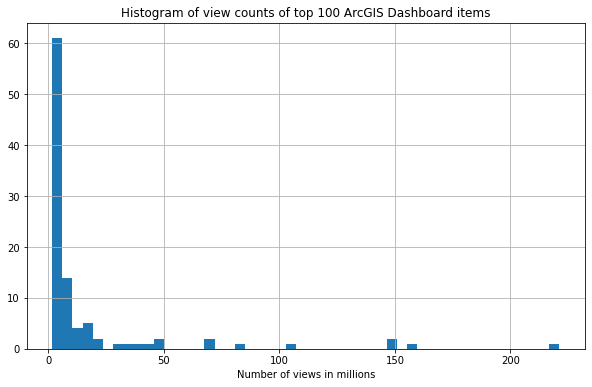

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
(df['num_views']/1000000).hist(bins=50)
ax.set_title(f'Histogram of view counts of top {search_items_max} ArcGIS {search_item_type} items')
ax.set_xlabel('Number of views in millions');

просмотр наиболее популярных элементов

In [15]:
for current_item in search_result[:4]:
    display(current_item)

<Item title:"Coronavirus COVID-19 (2019-nCoV)" type:Dashboard owner:CSSE_GISandData>

<Item title:"RKI COVID-19 Germany Mobil" type:Dashboard owner:help1@esri>

<Item title:"RKI COVID-19 Germany LK" type:Dashboard owner:help1@esri>

<Item title:"Covid19 MAIN FRONT MOB" type:Dashboard owner:15min.lt>

визуализируем дату последнего изменения в виде гистограммы. date_modifiedКолонка читается как DateTimeобъект с минуту и второго уровня данных. Мы повторно выберем этот столбец и будем агрегировать по дням.

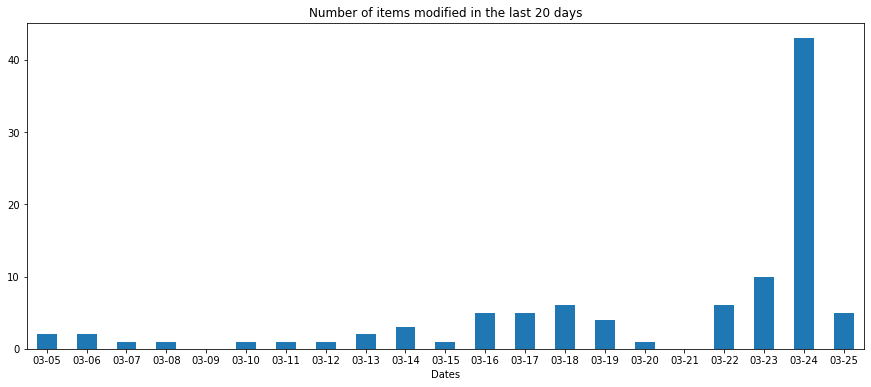

In [16]:
df2 = df.resample(rule='1D', on='date_modified')  # resample to daily intervals
last_modified_counts = df2['item_id'].count()

# simplify date formatting
last_modified_counts.index = last_modified_counts.index.strftime('%m-%d')

# plot last modified dates as a histogram
fig, ax = plt.subplots(figsize=(15,6))
last_modified_counts.plot(kind='bar', ax=ax)
ax.set(xlabel = 'Dates',
      title='Number of items modified in the last 20 days')
plt.xticks(rotation='horizontal');

библиотека для облака слов

In [17]:
!pip install wordcloud

собираем строки заголовков из всех элементов и объединяем их в длинный абзац

In [18]:
%%time
title_series = df['title'].dropna()
title_list = list(title_series)
title_paragraph = '. '.join(title_list)
title_paragraph

CPU times: user 1.97 ms, sys: 0 ns, total: 1.97 ms
Wall time: 1.99 ms


In [19]:
from wordcloud import WordCloud
wc = WordCloud(width=1000, height=600, background_color='white')

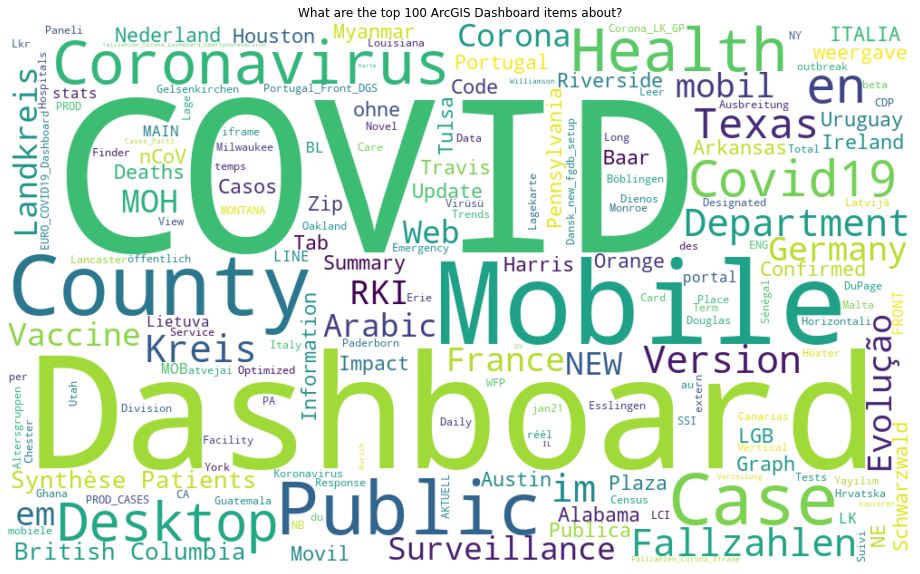

In [22]:
wc_img = wc.generate_from_text(title_paragraph)

plt.figure(figsize=(20,10))
plt.imshow(wc_img, interpolation="bilinear")
plt.axis('off')
plt.title('What are the top 100 ArcGIS Dashboard items about?');

In [26]:
# create a folder for these files if it does not exist

if not os.path.exists(out_folder):
    os.makedirs(out_folder)
    print(f'Created output folder at: {out_folder}')
else:
    print(f'Using existing output folder at: {out_folder}')

Using existing output folder at: /content/gis


In [27]:
# append timestamp to filename to make it unique
output_filename = f"top_dash_items_{start_time.strftime('%m-%d-%y')}_to_{end_time.strftime('%m-%d-%y')}"

# write table to csv
df.to_csv(os.path.join(out_folder, output_filename))
print('Output csv created at : ' + os.path.join(out_folder, output_filename))

Output csv created at : /content/gis/top_dash_items_03-04-21_to_03-24-21
